In [259]:
import numpy as np 
import pandas as pd
import scipy
import utils

TS = 48 # Time steps
UID = 1 # Householder ID
MBC = 50. # Max capacitiy of Battery
horizon = 48 # TS
Wc = 0.9 # weighting coefficient

# df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
# df = df.set_index(pd.to_datetime(df.index))
# df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
# df = df/1000.
# df_date = df.index
# df.head()

# customers = sorted(df.columns.levels[0])
# data_test = df[UID][['GG', 'GC']]
data_test, df_date = utils.load_data([UID])
load = data_test[0]['GC'].to_numpy()
pvgn = data_test[0]['GG'].to_numpy()

(17520, 2)



u : current soc
x0 : grid status(import/export power)
x1 : previous soc of battery (10% to 95%)
x2 : charging/discharging power for battery

In [260]:
def batt_model(u, x, pv, ld):
    # print('batt_model', u, x, pv, ld)
    x_next = np.zeros(3)
    x_next[0] = ld - pv + (u - x[1])
    x_next[1] = u
    x_next[2] = u - x[1] # current soc - previous soc 

    return x_next

In [261]:
import math 
def cal_sc(pv, ld, export):
    return (pv - export)/pv if pv > 0 else 0

def cal_ss(pv, ld, export):
    return (pv - export)/ld if ld > 0 else 0
    
def cost(u, x, pos, pv, ld):
    cost_val = 0.0
    export = 0.0
    tpv = 0.0
    tld = 0.0
    mlt = len(pv)
    w = 1.0
    for i in range(horizon):
        x =  batt_model(u[i], x, pv[(pos+i)%mlt], ld[(pos+i)%mlt])
        # cost_val += math.sqrt(x[0]**2)*w
        export += abs(x[0]) if x[0] < 0 else 0
        tpv += pv[(pos)%mlt]
        tld += ld[(pos+i)%mlt]
        w *= Wc

    sc = cal_sc(tpv, tld, export)
    ss = cal_ss(tpv, tld, export)
    cost_val -= sc + ss
    return cost_val

In [262]:
def constraint_0(u, x, pos, pv, ld):
    lpv = len(pv)
    xnext =  batt_model(u[0], x, pv[(pos)%lpv], ld[(pos)%lpv])
    return ld[(pos)%lpv] - pv[(pos)%lpv] + (u[0] - x[1]) - xnext[0]

def constraint_1(u, x, pos, pv, ld):
    lpv = len(pv)
    return (pv[(pos)%lpv] -  ld[(pos)%lpv]) - u[0]

def constraint_2(u, x, pos, pv, ld):
    lpv = len(pv)
    return (ld[(pos)%lpv] - pv[(pos)%lpv]) + u[0]


In [ ]:

LDT = len(load)
BCMIN = 0.10
BCMAX = 0.95
x0 = np.array([0, MBC*BCMIN, 0])
u0 = np.zeros(horizon)

u = []
x = []
for i in range(LDT):
    arguments = (x0, i, pvgn, load)
    constraints = ({'type': 'eq', "fun": constraint_0, 'args':arguments})
    # , 
    #                {'type': 'ineq', "fun": constraint_1, 'args':arguments},
    #                {'type': 'ineq', "fun": constraint_2, 'args':arguments})
    
    bnds = ((MBC*BCMIN, MBC*BCMAX),)
    # res = scipy.optimize.minimize(cost, u0, bounds=bnds, args=arguments, constraints=constraints)
    res = scipy.optimize.minimize(cost, u0, bounds=bnds, args=arguments, constraints=None, method="SLSQP")
    u0 = res.x.copy()

    x0 = batt_model(u0[0], x0, pvgn[(i)%LDT], load[(i)%LDT])
    
    u.append(u0[0])
    x.append(x0)
x = np.array(x)
print(res.x)
print(res.success)

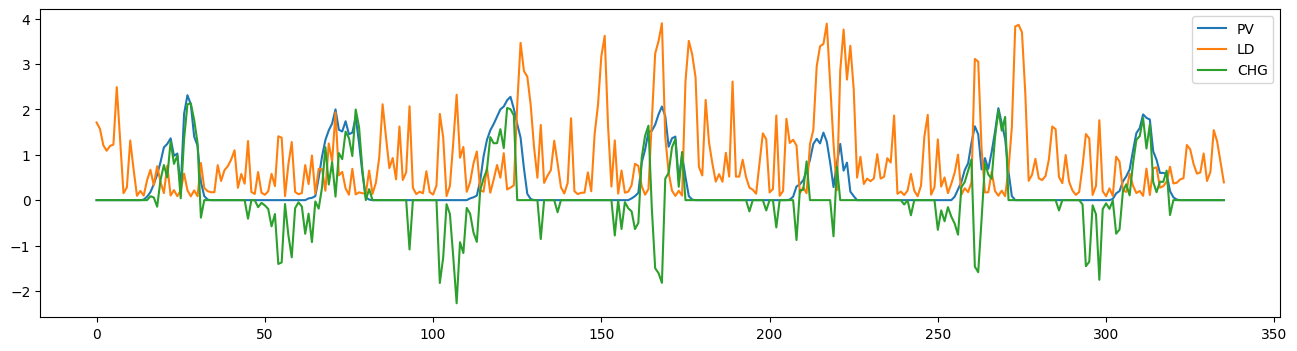

In [ ]:
import matplotlib.pyplot as plt 

start = TS*0
end = start+TS*7
fig = plt.figure(figsize=(16, 4))
# plt.plot(x[start:end, 0], label='GRD')
plt.plot(pvgn[start:end], label='PV')
plt.plot(load[start:end], label='LD')
plt.plot(x[start:end, 2], label='CHG')
# plt.plot(u[start:end], label='SOC')
plt.legend()


ValueError: x and y must have same first dimension, but have shapes (17520,) and (336,)

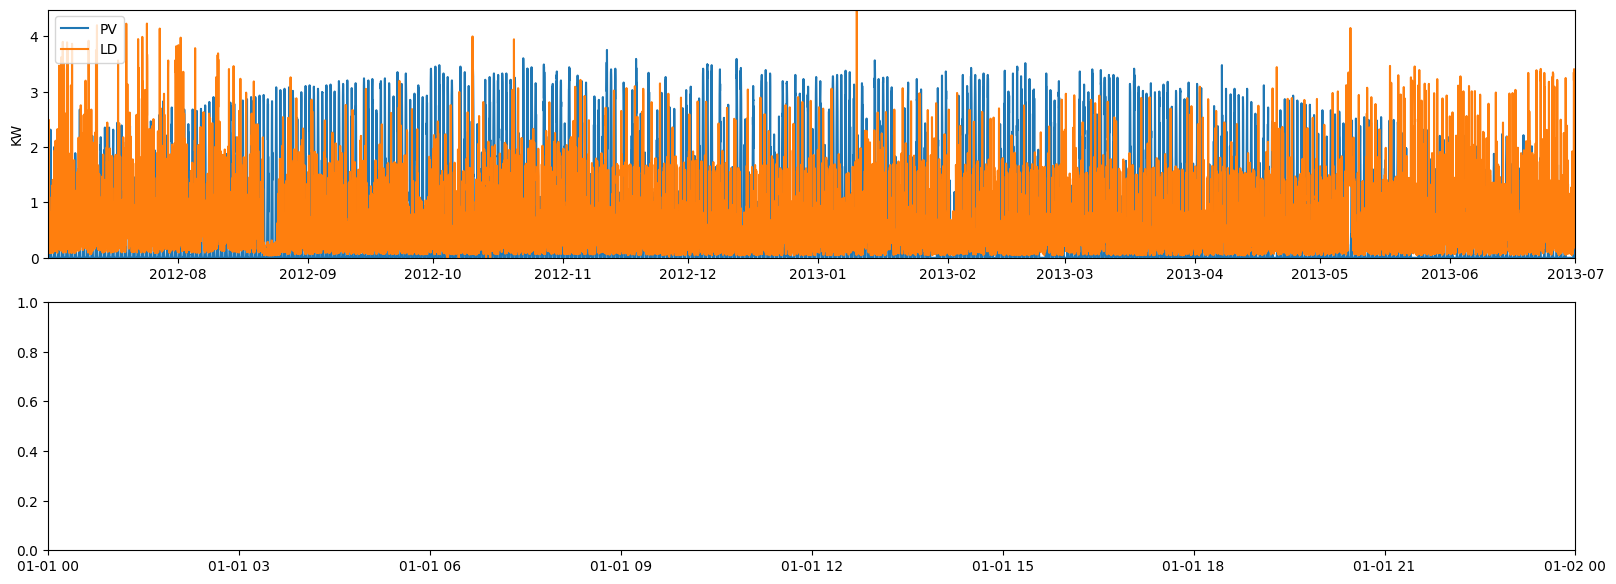

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
plt.rcParams["font.size"] = "10"
fig.tight_layout()

axes[0].plot(df_date.values, pvgn, label='PV', color='#1f77b4')
axes[0].plot(df_date.values, load, label='LD', color='#ff7f0e')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('KW')
axes[0].grid(False)
axes[0].margins(0,0)

axes[1].plot(df_date.values, x[:, 0], label='GD', color='#d62728')
axes[1].plot(df_date.values, u, label='BT', color='#2ca02c')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('KW')
axes[1].grid(False)
axes[1].margins(0,0)

In [ ]:
Egen = pvgn.sum()
print(Egen, 'KW')
Eload = load.sum()
print(Eload, 'KW')
GDimport = x[:, 0][x[:, 0]>0].sum()
print(GDimport)
GDexport = x[:, 0][x[:, 0]<0].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

10230.413999999999 KW
10559.768000000002 KW
189.36741430215227
-0.5323934416184104
SC : 0.9999479597363685
SS : 0.9687600718650616


In [19]:
df_out = pd.DataFrame()
df_out['Date'] = df_date
df_out['PV'] = pvgn
df_out['LD'] = load
df_out['GD'] = x[:,0]
df_out['BT'] = x[:,1]
df_out['CH'] = x[:,2]

df_out.to_csv('mpc_hzn.csv')
df_out.set_index('Date', inplace=True)

(-5.0, 5.0)

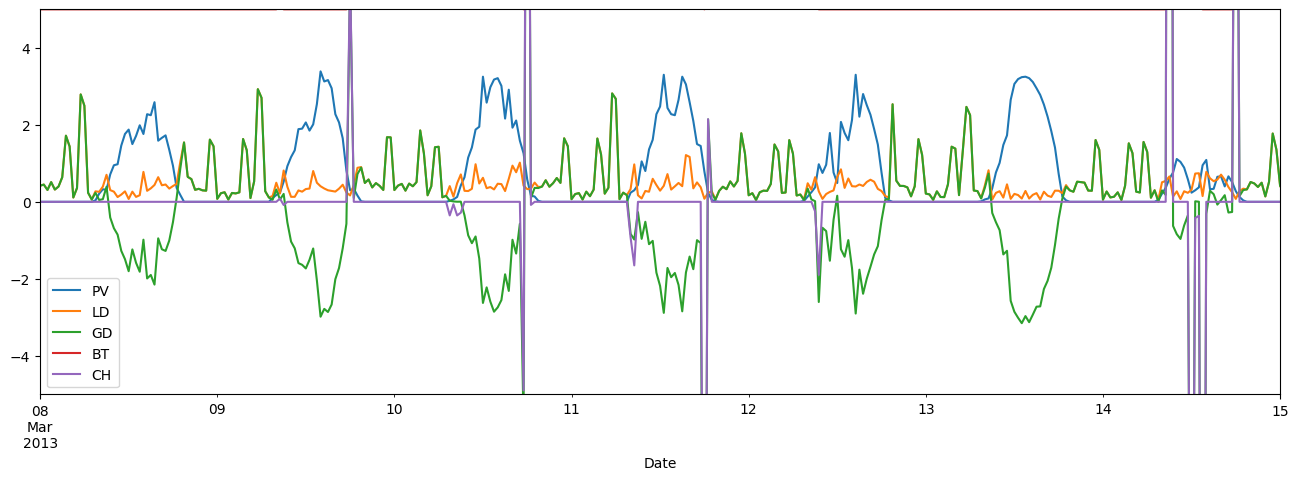

In [ ]:
ax = df_out.plot(figsize=(16,5))
ax.set_xlim(pd.Timestamp('2013-03-08 00:00:00'), pd.Timestamp('2013-03-15 00:00:00'))
ax.set_ylim(-5, 5)